# Approximate Dynamic Programming

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define MDP parameters
N = 100
p = 0.5
q_low = 0.51
q_high = 0.6
c_low = 0
c_high = 0.05
gamma = 0.99
# a_low = "alow"
# a_high = "ahigh"
# action=[a_low,a_high]
# a=100000
# b=100000

In [3]:
# Define the reward function
def reward(x, a):
  return -(x/N)**2 - (c_low if a == 0 else c_high)

reward_low=np.zeros((N))
reward_high=np.zeros((N))
for s in range(0,N):
  reward_low[s]= reward(s,0)
  reward_high[s]= reward(s,1)


In [4]:
# Define the transition function
# the probability of state y given state x and action a
def grid_env(N):
  T = np.zeros((N, N, 2))

  for a in range(0,2):

    p_inc = p
    p_dec = q_low if a == 0 else q_high

    p00= (1-p_inc) * (1-p_dec)
    p11= p_inc * p_dec
    p10= p_inc*(1-p_dec)
    p01= (1-p_inc)*p_dec

    for x in range(0,N):
      #inc=dec=0 or inc=dec=1
      T[x,x,a]= p00 + p11

      #inc=1 dec=0
      if(x==N-1):
        T[x,x,a] += p10
      else: T[x, x+1,a]= p10

      #inc=0 dec=1
      if(x==0):
        T[x,x,a] += p01
      else: T[x,x-1,a]= p01

  return T

In [5]:
# Define transition function matrix and the rewards for the problem
P = grid_env(N)

r_lazy=reward_low

first_50_of_low = reward_low[:50]
last_50_of_high = reward_high[-50:]
r_aggr = []
r_aggr.extend(first_50_of_low)
r_aggr.extend(last_50_of_high)

In [6]:
# define policies
# prob of actian a in state x

policy_lazy= np.zeros((N,2))
for i in range(0,N):
  policy_lazy[i,0]=1


policy_aggr= np.zeros((N,2))
for i in range(0,50):
  policy_aggr[i,0]=1
for i in range(50,N):
  policy_aggr[i,1]=1

# lazy_policy= np.zeros(N)
# for i in range(0,N):
#   policy_lazy[i]=0 #action low

# aggr_policy = np.zeros(N)
# for i in range(0,50):
#   policy_aggr[i]=0 #action low
# for i in range(50,N):
#   policy_aggr[i]=1 #action high

lazy_policy = [0] * N
aggr_policy = [0 if i < 50 else 1 for i in range(N)]


In [7]:
def phi_fine(x, N):
    # x: The current state (integer).
    # N: Total number of states in the MDP.
    # returns N-dimensional feature vector corresponding to state x.

    feature_vector = np.zeros(N)
    feature_vector[x] = 1
    return feature_vector


In [8]:
def phi_coarse(x, N):
    # x: The current state (integer).
    # N: Total number of states in the MDP.
    # return: (N/5)-dimensional feature vector corresponding to state x.

    num_features = N // 5
    feature_vector = np.zeros(num_features)

    # Determine which feature should be active based on the current state
    feature_index = x // 5
    feature_vector[feature_index] = 1

    return feature_vector


In [9]:
def phi_piecewise_linear(x, N):
    num_features = N // 5
    feature_vector = np.zeros(2 * num_features)

    segment_index = x // 5
    feature_vector[segment_index] = 1  # Coarse feature

    linear_index = num_features + segment_index
    feature_vector[linear_index] = (x - 5 * segment_index) / 5.0  # Linear feature

    return feature_vector


In [10]:

def get_next_state(state, action, P) :
  transition_probs = P[state,:,action]
  next_state = np.random.choice(np.arange(N), p=transition_probs)
  return next_state


In [11]:

# def sample_transitions(policy, start_state, num_transitions, P):
#     state = start_state
#     transitions = []

#     for _ in range(num_transitions):
#         action = policy[state]
#         next_state = get_next_state(state, action,P)
#         transitions.append((state, next_state, action))
#         state = next_state

#     return transitions



In [12]:
fine_features = np.array([phi_fine(s, N) for s in range(N)])
coarse_features = np.array([phi_coarse(s, N) for s in range(N)])
piecewise_linear_features = np.array([phi_piecewise_linear(s, N) for s in range(N)])

In [13]:

def LSTD(transitions, gamma, feature_map, N):

    num_features = feature_map.shape[1]

    A = np.zeros((num_features, num_features))
    b = np.zeros(num_features)

    # Accumulate A and b
    for (state, next_state, action) in transitions:

        phi_state = feature_map[state]
        phi_next_state = feature_map[next_state]

        A += np.outer(phi_state, phi_state - gamma * phi_next_state)
        b += phi_state * reward(state, action)

    # Solve for weights
    weights = np.linalg.pinv(A) @ b

    # Compute the value function for each state
    value_function = np.zeros(N)
    for state in range(N):
        phi_state = feature_map[state]
        value_function[state] = np.dot(weights, phi_state)

    return value_function


In [14]:

def sample_transitions(policy, start_state, num_transitions, P):
    state = start_state
    transitions = []

    for _ in range(num_transitions):
        # Get the action probabilities for the current state
        action_probabilities = policy[state]

        # Choose an action based on the probability distribution
        action = np.random.choice(len(action_probabilities), p=action_probabilities)

        # Get the next state based on the current state and action
        next_state = get_next_state(state, action, P)

        # Append the transition to the list
        transitions.append((state, next_state, action))

        # Update the current state
        state = next_state

    return transitions


In [15]:
def soft_policy_iteration(P, max_iter, start_state, number_transitions, gamma, feature_map, eta):
  # Initialize uniform policy
  policy = np.zeros((N,2))
  for a in range(2):
    for x in range(N):
      policy[x,a]=1/2

  last_state = start_state
  total_reward=0

  for k in range(max_iter):
    #   print("Iteration: ", k)
      # Policy Evaluation: Using LSTD
      transitions = sample_transitions(policy, last_state, number_transitions, P)
      V = LSTD(transitions, gamma, feature_map, N)
      last_state = transitions[-1][1]

      # Policy Improvement
      for x in range(N):
          Q_values = np.zeros(2)
          for a in range(2):
              q_action = q_low if a == 0 else q_high  # Replace with your method to determine q(a)

              # Q-value computation incorporating the transition dynamics
              Q_values[a] = ( reward(x, a)
                            + gamma * (1 - p) * ( q_action * V[max(x - 1, 0)] + ( 1 - q_action ) * V[x] )
                            + gamma * p * ( q_action * V[x] + ( 1 - q_action ) * V[min(x + 1, 99)] )
              )

          # Adjust Q-values to avoid numerical issues
          Q_values -= np.max(Q_values)

          # Calculate the denominator of the softmax
          denominator = sum([policy[x, a_prime] * np.exp(eta * Q_values[a_prime]) for a_prime in range(2)])

          # Update the policy for each action
          for a in range(2):
              numerator = policy[x, a] * np.exp(eta * Q_values[a])
              policy[x, a] = numerator / denominator

          # total_reward += reward(x, np.argmax(policy[x]) )
      total_reward += np.sum([reward(t[0], t[2]) for t in transitions])

  return total_reward


In [16]:

# Given parameters
T = 10**5  # Total number of timesteps
K = 100    # Number of episodes
M = 100    # Number of different η values

# Generate η values
etas = np.logspace(-2, 2, num=M)

# Initialize array to store total rewards for each η
rewards = []

for eta in etas:
    print("------------Running eta: ", eta)
    total_reward = soft_policy_iteration(P, K, 99, T, gamma, piecewise_linear_features, eta)
    rewards.append(total_reward)


------------Running eta:  0.01
------------Running eta:  0.010974987654930561
------------Running eta:  0.012045035402587823
------------Running eta:  0.013219411484660288
------------Running eta:  0.014508287784959394
------------Running eta:  0.015922827933410922
------------Running eta:  0.01747528400007684
------------Running eta:  0.019179102616724886
------------Running eta:  0.02104904144512021
------------Running eta:  0.023101297000831605
------------Running eta:  0.025353644939701114
------------Running eta:  0.027825594022071243
------------Running eta:  0.030538555088334154
------------Running eta:  0.033516026509388425
------------Running eta:  0.03678379771828634
------------Running eta:  0.040370172585965536
------------Running eta:  0.044306214575838825
------------Running eta:  0.04862601580065353
------------Running eta:  0.0533669923120631
------------Running eta:  0.05857020818056667
------------Running eta:  0.06428073117284322
------------Running eta:  0.070548023

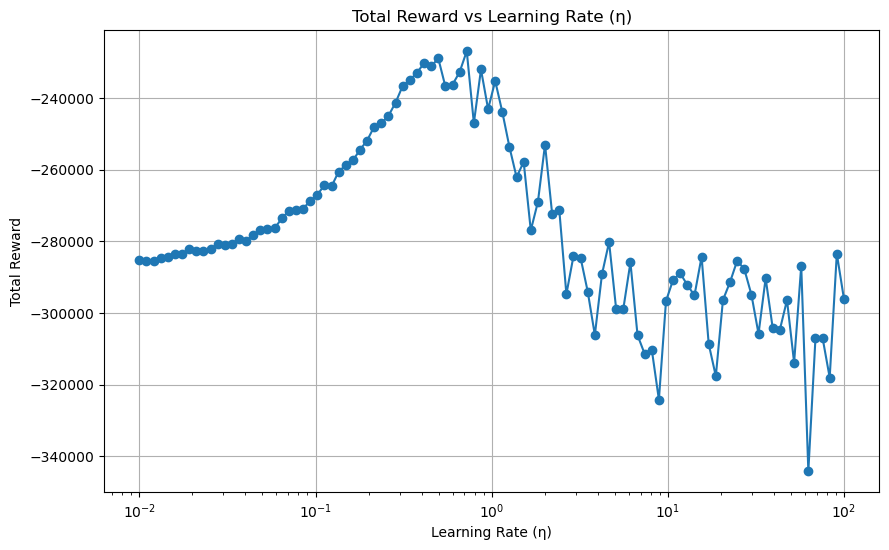

In [18]:
# Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(etas, rewards, marker='o', linestyle='-')
plt.xlabel('Learning Rate (η)')
plt.ylabel('Total Reward')
plt.xscale('log')
plt.title('Total Reward vs Learning Rate (η)')
plt.grid(True)
plt.show()


 The plot indicates that lower values of η, particularly < 1, perform consistently better, as evidenced by the higher total reward (or in this case, less negative, which is still better). The plot remains relatively flat in this region, suggesting that the policy iteration is stable and effective within this range of η values. As η increases, there is a notable decline in performance, which is shown by the decrease in total reward. This suggests that as the learning rate increases, the policy iteration may be becoming less stable, potentially overshooting the optimal policy. Very high values of η, show a significant drop in performance and a high variance in the total reward. This indicates poor performance, likely because the high learning rate causes the policy updates to be too aggressive, which can prevent convergence or lead to divergence from the optimal policy.

 The plot indicates that a “soft” policy iteration approach may offer an advantage over “hard” policy iteration if the learning rate η is chosen correctly. The best-performing values of η seem to be those that maintain a balance between sufficient exploration of the policy space (not too low) and maintaining stability in policy updates (not too high).
